# Model Postamat


In [956]:
# imports
import pandas as pd
import numpy as np
import re
import geopandas

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

In [957]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler



## Load data

In [958]:
PATH_DATASET = "datasets/"
PATH_DATASET_RESULT = PATH_DATASET + "result/"
COUNT_POPULATION = 5000

In [959]:
# Load dataset
train_filename = PATH_DATASET_RESULT + "dataset_for_model.csv"
test_filename = PATH_DATASET_RESULT + "df_object_hexagon_9.csv"

train_df = pd.read_csv(train_filename, sep=";").iloc[:,2:]
test_df = pd.read_csv(test_filename, sep=";").iloc[:,2:]
train_df = train_df.drop(columns=['count_house_flat_x2',  'count_houses_x2',  'count_nearest_auto_parking_x2',  'count_nearest_metro_x2',  'count_nearest_ngpt_x2',  'food_delivery_x2',  'population_house_flat_x2',  'population_house_living_square_x2',  'population_house_square_x2',  'velo_parking_x2'])
test_df = test_df.drop(columns=['count_house_flat_x2',  'count_houses_x2',  'count_nearest_auto_parking_x2',  'count_nearest_metro_x2',  'count_nearest_ngpt_x2',  'food_delivery_x2',  'population_house_flat_x2',  'population_house_living_square_x2',  'population_house_square_x2',  'velo_parking_x2'])
train_df.shape, test_df.shape

((7736, 64), (64455, 63))

In [960]:
# Исключаем из обучения признаки с данными о постаматах, наимеванояи и сопроводительные признаки (долгота, широат, окато и прочее)
drop_columns = ["type", "name","geometry_name", "lon", "lat", "okato", "normalize_name", "covering_postamats", 'count_nearest_postamats', 'count_nearest_postamats_x2', "count_nearest_postamats_x3", "count_competitor_pvz_postamat", "count_competitor_pvz_postamat_x2", "digitalization", "turnover_postamats", "geometry", "okrug", "target", "count_nearest_pvz", "count_nearest_pvz_x2",  "count_competitor_pvz_postamat", "count_competitor_pvz_postamat_x2", "count_nearest_pvz_shop", "count_nearest_pvz_shop_x2",]
drop_columns = ["type", "name","geometry_name", "lon", "lat", "okato", "normalize_name", "covering_postamats", 'count_nearest_postamats', 'count_nearest_postamats_x2', "count_nearest_postamats_x3", "count_competitor_pvz_postamat", "count_competitor_pvz_postamat_x2", "digitalization", "turnover_postamats", "geometry", "okrug", "target", "count_nearest_pvz", "count_nearest_pvz_x2",  "count_competitor_pvz_postamat", "count_competitor_pvz_postamat_x2", ]
num_cols = list(train_df.columns)
num_cols = list(set(num_cols) - set(drop_columns))
target_col = ["target"]

train_df[num_cols]

,velo_parking,digitalization_without_postamat_normal,count_nearest_ngpt,K_distance,count_small_enterprises,prc_children_1_6,population_house_flat,rating_ecology,prc_xenophobic,population_house_living_square,prc_employees_small_businesses,count_house_flat,house_infrastructure_rating,transportization_norm,transportization,digitalization_without_postamat,region_average_age,prc_children_5_18,area_per_human_region,count_nearest_pvz_shop_x2,death_rate,population_region,population_density_region,budget_revenues,count_nearest_metro,investments,population_house_square,average_salary,level_sleeping_region,count_nearest_pvz_shop,food_delivery,natural_population_growth,total_fertility_rate,level_working_region,region_population,count_houses,budget_expenditures,count_nearest_auto_parking,cost_apartment,distance_to_center,price_metr_housing,prc_people_higher_education,migration_population_growth,entertainment_infrastructure,average_employees,level_sleep_work_region
0,0,0.305714,5,0.1949,917,6.69,4921,7,11.48,3822,39.62,1538,36,0.025713,4.25,4.820467,41.7,12.10,17.4,9,9.7,93400,7414,23881,0,578763,4800,99175,7980,4,1,-3.3,6.4,46799,93400,16,22817,2,41185,4.710252,205429,48.47,7.7,85,58801,0.170516
1,0,0.288655,3,0.1949,917,6.69,4540,7,11.48,4093,39.62,1419,36,0.017882,2.95,4.700467,41.7,12.10,17.4,14,9.7,93400,7414,23881,0,578763,5017,99175,25112,5,0,-3.3,6.4,89873,93400,7,22817,2,41185,5.702885,205429,48.47,7.7,85,58801,0.279417
2,0,0.288655,3,0.1949,917,6.69,4764,7,11.48,4300,39.62,1489,36,0.017882,2.95,4.700467,41.7,12.10,17.4,18,9.7,93400,7414,23881,0,578763,5254,99175,25112,5,0,-3.3,6.4,89873,93400,8,22817,2,41185,5.700306,205429,48.47,7.7,85,58801,0.279417
3,0,0.288655,3,0.1949,917,6.69,4764,7,11.48,4300,39.62,1489,36,0.017882,2.95,4.700467,41.7,12.10,17.4,18,9.7,93400,7414,23881,0,578763,5254,99175,25112,5,0,-3.3,6.4,89873,93400,8,22817,2,41185,5.700306,205429,48.47,7.7,85,58801,0.279417
4,1,0.352846,7,0.1949,917,6.69,6222,7,11.48,5763,39.62,1944,36,0.153965,7.35,8.530467,41.7,12.10,17.4,16,9.7,93400,7414,23881,1,578763,7371,99175,25112,7,0,-3.3,6.4,89873,93400,14,22817,4,41185,5.726264,205429,48.47,7.7,85,58801,0.279417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,0,0.130940,2,0.1949,180,3.86,4076,30,25.89,3650,47.62,1274,14,0.007831,1.30,3.000750,41.6,5.83,11.1,2,9.6,8600,455,48422,0,159992,4834,156344,7341,1,0,2.9,12.5,3172,8600,5,25603,0,15556,27.302716,98557,33.05,38.4,0,568,2.314313
7732,0,0.130940,1,0.1949,180,3.86,7712,30,25.89,7348,47.62,2410,14,0.003916,0.65,3.000750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,9730,156344,7261,1,0,2.9,12.5,3138,8600,8,25603,0,15556,27.443196,98557,33.05,38.4,0,568,2.313894
7733,0,0.127999,1,0.1949,180,3.86,7267,30,25.89,8217,47.62,2271,14,0.003916,0.65,2.600750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,10871,156344,4579,0,0,2.9,12.5,1896,8600,7,25603,0,15556,27.478005,98557,33.05,38.4,0,568,2.415084
7734,0,0.112312,0,0.1949,180,3.86,5232,30,25.89,6072,47.62,1635,14,0.000000,0.00,1.800750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,8039,156344,4595,0,0,2.9,12.5,1903,8600,6,25603,0,15556,27.449695,98557,33.05,38.4,0,568,2.414609


In [961]:

# train_df = train_df.drop(columns=drop_columns)
# num_cols = list(test_df.drop(columns=drop_columns).columns)
# test_df = test_df[num_cols]

# num_cols = ['distance_to_center',
# #        'count_nearest_postamats', 
# #         'count_nearest_postamats_2km',
#        'count_nearest_pvz', 'food_delivery', 'digitalization',
#        'covering_postamats', 'count_nearest_metro',
#        'count_nearest_ngpt', 'level_working_region', 'level_sleeping_region',
# #        'count_house_flat', 'population_house_flat', 'population_house_square',
# #        'population_house_living_square', 
#             'count_house_flat_400',
#        'population_house_flat_400', 'population_house_square_400',
#        'population_house_living_square_400', 
# #             'count_house_flat_200',
# #        'population_house_flat_200', 'population_house_square_200',
# #        'population_house_living_square_200'
#            ]
# cat_cols = []
# bin_cols = [] # 0/1

train_df.isna().sum()


type                                         0
name                                         0
geometry_name                                4
lon                                          0
lat                                          0
geometry                                  7169
K_distance                                   0
distance_to_center                           0
normalize_name                               0
okato                                        0
prc_children_1_6                             0
region_average_age                           0
prc_people_higher_education                  0
count_nearest_postamats                      0
count_nearest_postamats_x2                   0
count_nearest_pvz                            0
count_nearest_pvz_x2                         0
count_nearest_pvz_shop                       0
count_nearest_pvz_shop_x2                    0
count_competitor_pvz_postamat                0
count_competitor_pvz_postamat_x2             0
food_delivery

## Preprocessing dataset

# Data analysis
## Correlation matrix

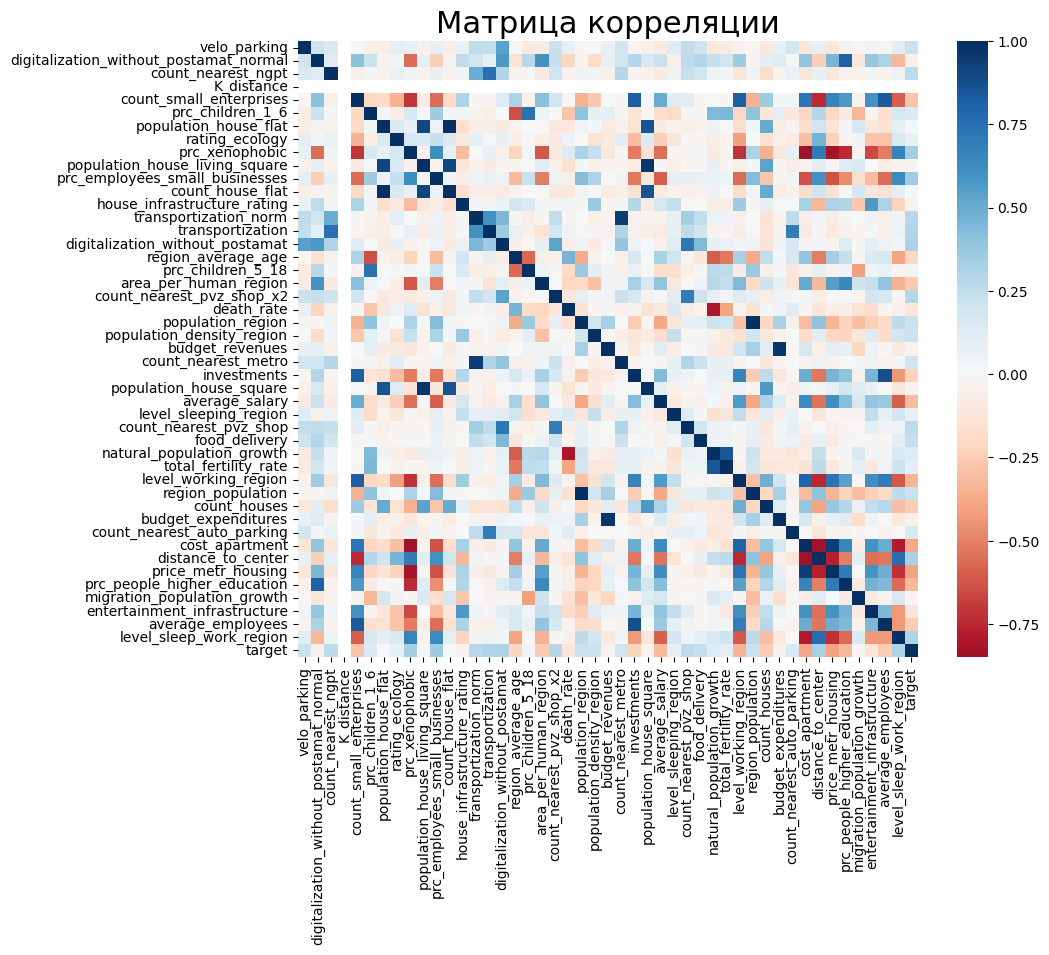

In [962]:
correlation = train_df[num_cols + target_col].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    cmap="RdBu",
    center=0,
)

plt.title("Матрица корреляции", fontsize=22)
plt.show()

# Create models

## Normalization + split train/test

In [963]:
y_data = train_df[target_col]
clear_y_data = y_data.values[:,0]
x_data = train_df[num_cols].copy().sort_index()
# test_df_mini = test_df[test_df["population_house_living_square"] > COUNT_POPULATION]
# x_data_test_full = test_df[num_cols + cat_cols + bin_cols].copy().sort_index()
x_data_test = test_df[num_cols].copy().sort_index()

y_data_ohe = np.array([[1-targ, targ] for targ in clear_y_data])
x_data.shape, x_data_test.shape, y_data_ohe.shape

((7736, 46), (64455, 46), (7736, 2))

In [964]:
# Разбиваем данные на train, test, val
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val, clear_y_train, clear_y_val = train_test_split(x_data, y_data_ohe, clear_y_data, train_size = 0.8,  shuffle=True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape


((6188, 46), (1548, 46), (6188, 2), (1548, 2))

In [965]:
train_df[target_col].value_counts()

target
1         4091
0         3645
dtype: int64

In [966]:
# x_train.columns
# num_cols


In [967]:
scaler = StandardScaler()
scaler.fit(x_train)


x_train_normalize = scaler.transform(x_train)
x_val_normalize = scaler.transform(x_val)
x_test_normalize= scaler.transform(x_data_test)
# x_test_normalize= scaler.transform(x_data_test[x_data_test["population_house_living_square"]>COUNT_POPULATION])


x_train_normalize.shape, x_val_normalize.shape, x_test_normalize.shape

((6188, 46), (1548, 46), (64455, 46))

## Create and fit Tensorflow model

In [968]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout


Epoch 1/20
31/31 [==============================] - 17s 111ms/step - loss: 0.4413 - accuracy: 0.8009 - auc: 0.8839 - precision: 0.8009 - recall: 0.8009 - val_loss: 0.3480 - val_accuracy: 0.8372 - val_auc: 0.9257 - val_precision: 0.8372 - val_recall: 0.8372
Epoch 2/20
31/31 [==============================] - 1s 42ms/step - loss: 0.3062 - accuracy: 0.8686 - auc: 0.9431 - precision: 0.8686 - recall: 0.8686 - val_loss: 0.2902 - val_accuracy: 0.8844 - val_auc: 0.9458 - val_precision: 0.8844 - val_recall: 0.8844
Epoch 3/20
31/31 [==============================] - 1s 46ms/step - loss: 0.2460 - accuracy: 0.8987 - auc: 0.9619 - precision: 0.8987 - recall: 0.8987 - val_loss: 0.2575 - val_accuracy: 0.8953 - val_auc: 0.9556 - val_precision: 0.8953 - val_recall: 0.8953
Epoch 4/20
31/31 [==============================] - 1s 42ms/step - loss: 0.2271 - accuracy: 0.9068 - auc: 0.9662 - precision: 0.9068 - recall: 0.9068 - val_loss: 0.2042 - val_accuracy: 0.9180 - val_auc: 0.9692 - val_precision: 0.9180

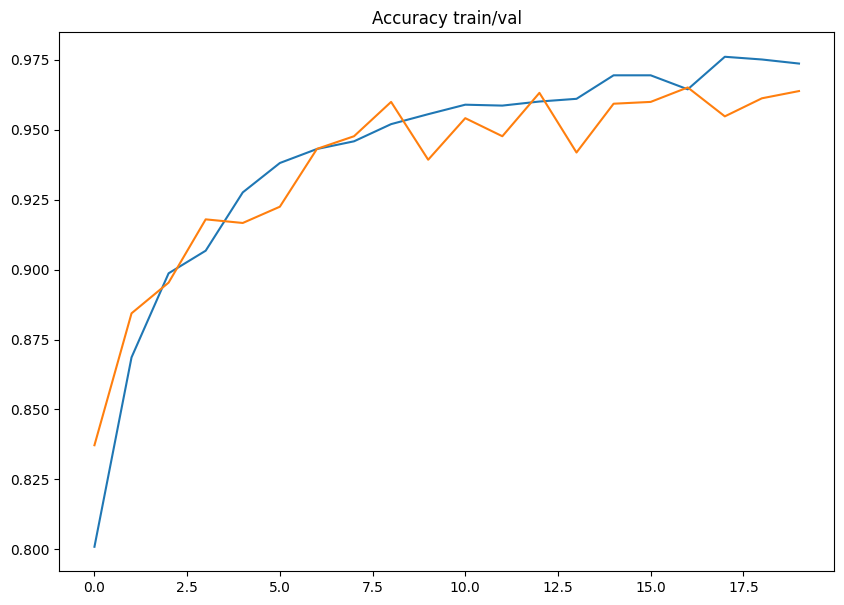

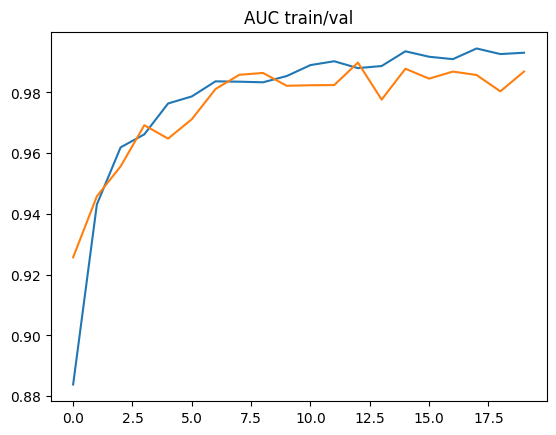

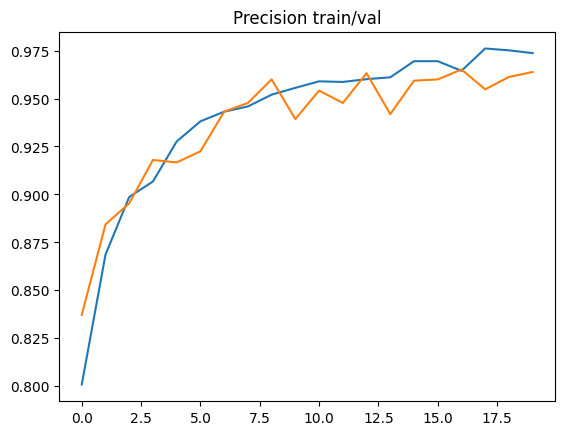

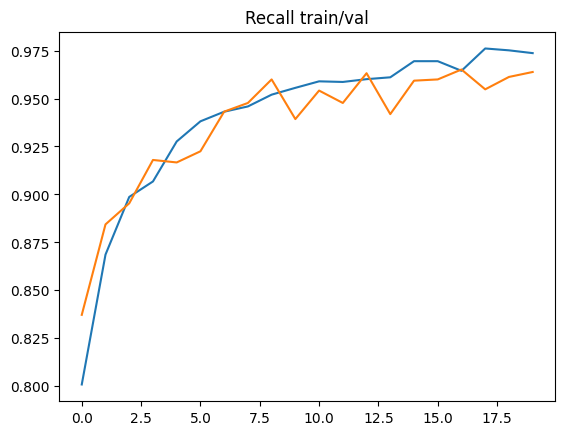

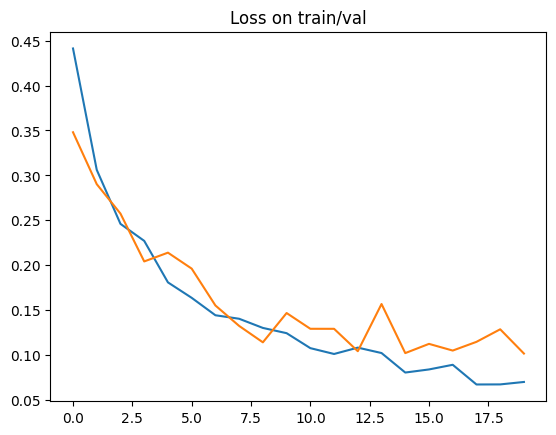

In [969]:
model = Sequential()
model.add(Dense(2800, input_shape=(x_train_normalize.shape[1:]), activation="tanh"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1400, activation="tanh")) 
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(800, activation="tanh"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(400, activation="tanh"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(200, activation="tanh"))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(50, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="softmax"))
model.compile( optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy", "AUC", "Precision", "Recall"] ) 

history = model.fit( x_train_normalize, y_train, epochs=20, validation_data=(x_val_normalize, y_val), verbose=True, batch_size=200)

plt.figure(figsize=(10,7))

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy train/val")
plt.show()

plt.plot(history.history["auc"], label="auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("AUC train/val")
plt.show()


plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["val_precision"], label="val_precision")
plt.title("Precision train/val")
plt.show()

plt.plot(history.history["recall"], label="recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.title("Recall train/val")
plt.show()



plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss on train/val")
plt.show()

## Fit models sklearn
Create and fit models sklearn:

    - AdaBoostClassifier
    - GradientBoostingClassifier
    - DecisionTreeClassifier
    - RandomForestClassifier
    - ExtraTreesClassifier
    - HistGradientBoostingClassifier
    - LogisticRegression

In [970]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()
ada_model.fit(x_train_normalize, clear_y_train)

ada_predict_val = ada_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, ada_predict_val)


0.8586001868967589

In [971]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gradient_model.fit(x_train_normalize, clear_y_train)

gradient_predict_val = gradient_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, gradient_predict_val)

0.8663486849279677

In [972]:
from sklearn.tree import DecisionTreeClassifier

decis_model = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
decis_model.fit(x_train_normalize, clear_y_train)
decis_predict_val = decis_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, decis_predict_val)

0.936420708966179

In [973]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
forest_model.fit(x_train_normalize, clear_y_train)
forest_predict_val = forest_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, forest_predict_val)

0.9624772041318612

In [974]:
from sklearn.calibration import CalibratedClassifierCV
forest_model_for_calibr = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

calibrated_forest_model = CalibratedClassifierCV(forest_model_for_calibr, cv=10)
calibrated_forest_model.fit(x_train_normalize, clear_y_train)

calibrated_forest_predict_val = calibrated_forest_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, calibrated_forest_predict_val)

0.9685085672199191

In [975]:
from sklearn.ensemble import ExtraTreesClassifier

extra_model = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
extra_model.fit(x_train_normalize, clear_y_train)
extra_predict_val = extra_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, extra_predict_val)

0.9690622111195182

In [976]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_model = HistGradientBoostingClassifier(max_iter=100)
hist_gradient_model.fit(x_train_normalize, clear_y_train)
hist_gradient_predict_val = hist_gradient_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, hist_gradient_predict_val)

0.9672100206190409

In [977]:
from sklearn.linear_model import LogisticRegression

logler_model = LogisticRegression(solver='liblinear', C=4, penalty='l1')
logler_model.fit(x_train_normalize, clear_y_train)
logler_predict_val = logler_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, logler_predict_val)

0.791032982077037

In [978]:
from sklearn.ensemble import VotingClassifier
voting_model = VotingClassifier(
    estimators=[
                ('ada_model', ada_model), 
                ('calibrated_forest_model', calibrated_forest_model), 
#                 ('decis_model', decis_model), 
                ('forest_model', forest_model), 
                ('extra_model', extra_model), 
                ('logler_model', logler_model),                 
               ],    voting='soft')

voting_model.fit(x_train_normalize, clear_y_train)
voting_predict_val = voting_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, voting_predict_val)

0.9658192000348963

In [979]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
estimators=[
            ('ada_model', ada_model), 
            ('forest_model', forest_model), 
            ('extra_model', extra_model), 
            ('logler_model', logler_model),
           ]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(x_train_normalize, clear_y_train)
stacking_predict_val = stacking_model.predict(x_val_normalize)
roc_auc_score(clear_y_val, stacking_predict_val)

0.9730073433313593

### Feature importances 

<AxesSubplot:title={'center':'Feature importances'}>

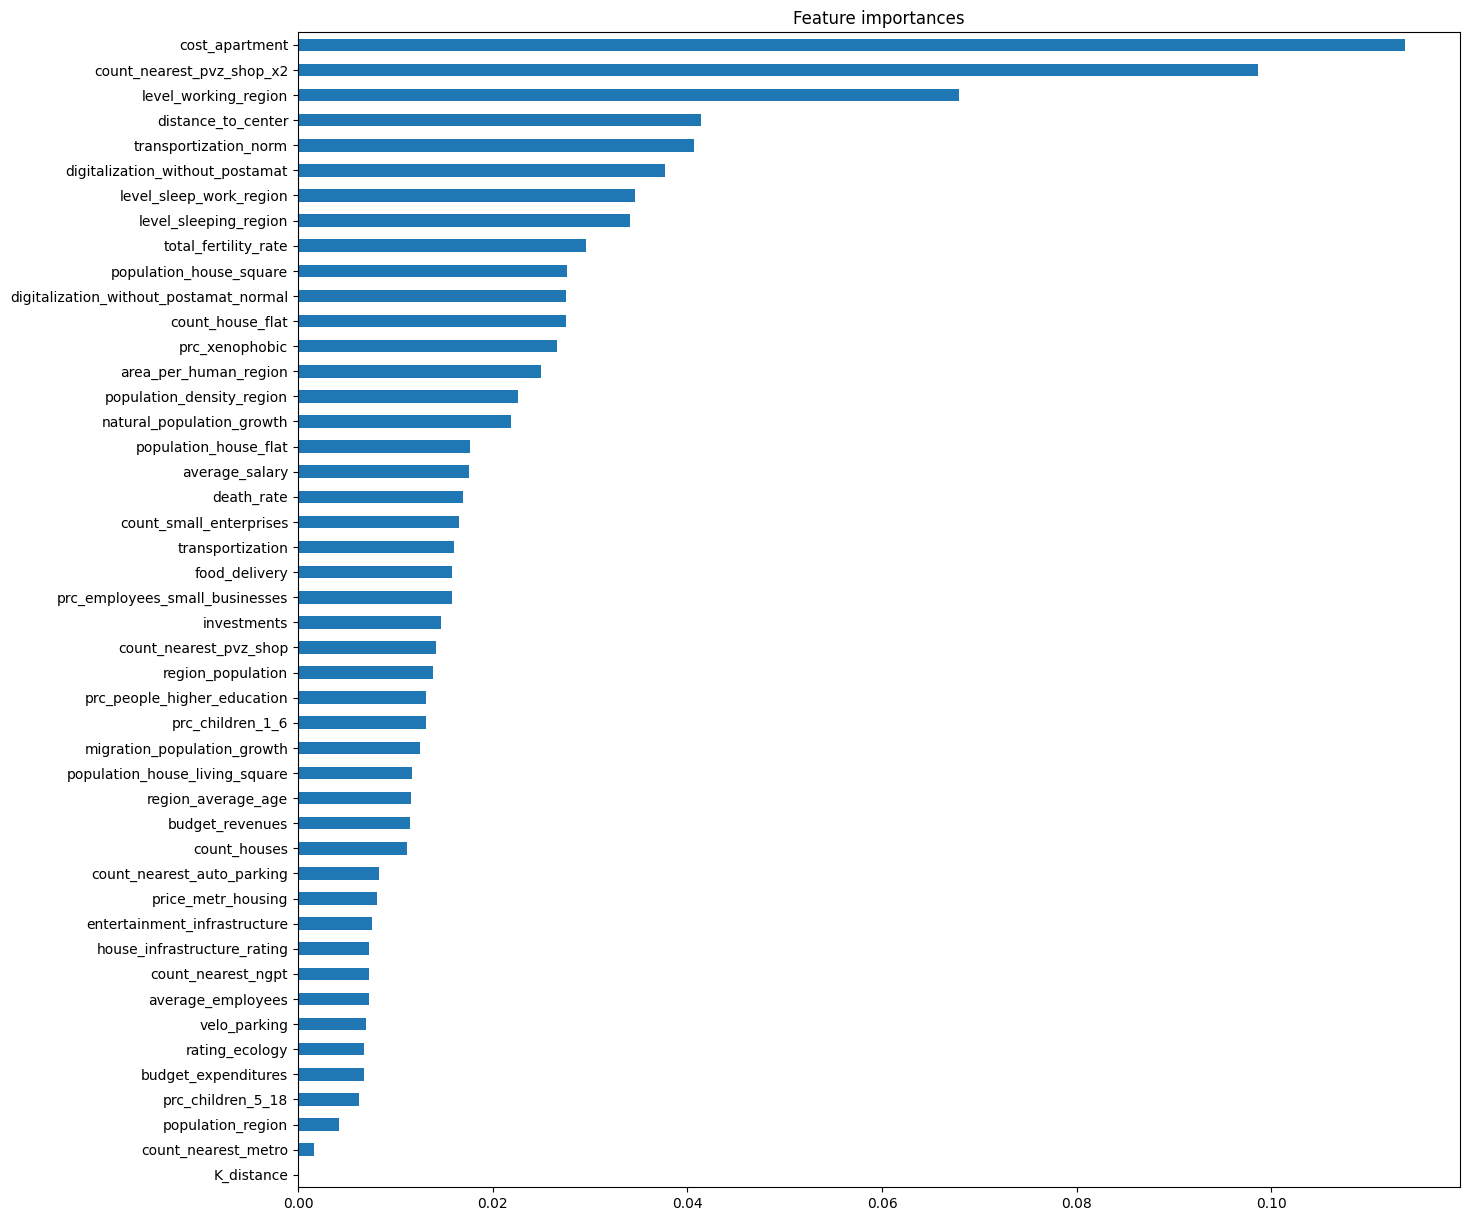

In [980]:
# Формируем важность признаков по тем моделям, где есть возможность
def get_feature_importances(model, df, num_cols):
    feature_importances = pd.Series(model.feature_importances_, index=num_cols)
    return df.append(feature_importances, ignore_index=True)

importan_features_df = pd.DataFrame()
importan_features_df = get_feature_importances(ada_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(gradient_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(decis_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(forest_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(extra_model, importan_features_df, num_cols)


# Выводим сагрегированную важность признаков
importan_features_df.mean().nsmallest(x_train.shape[1]).plot(kind='barh', title="Feature importances", figsize=(15,15))

In [981]:
x_train.shape[1]

46

<AxesSubplot:title={'center':'Feature importances'}>

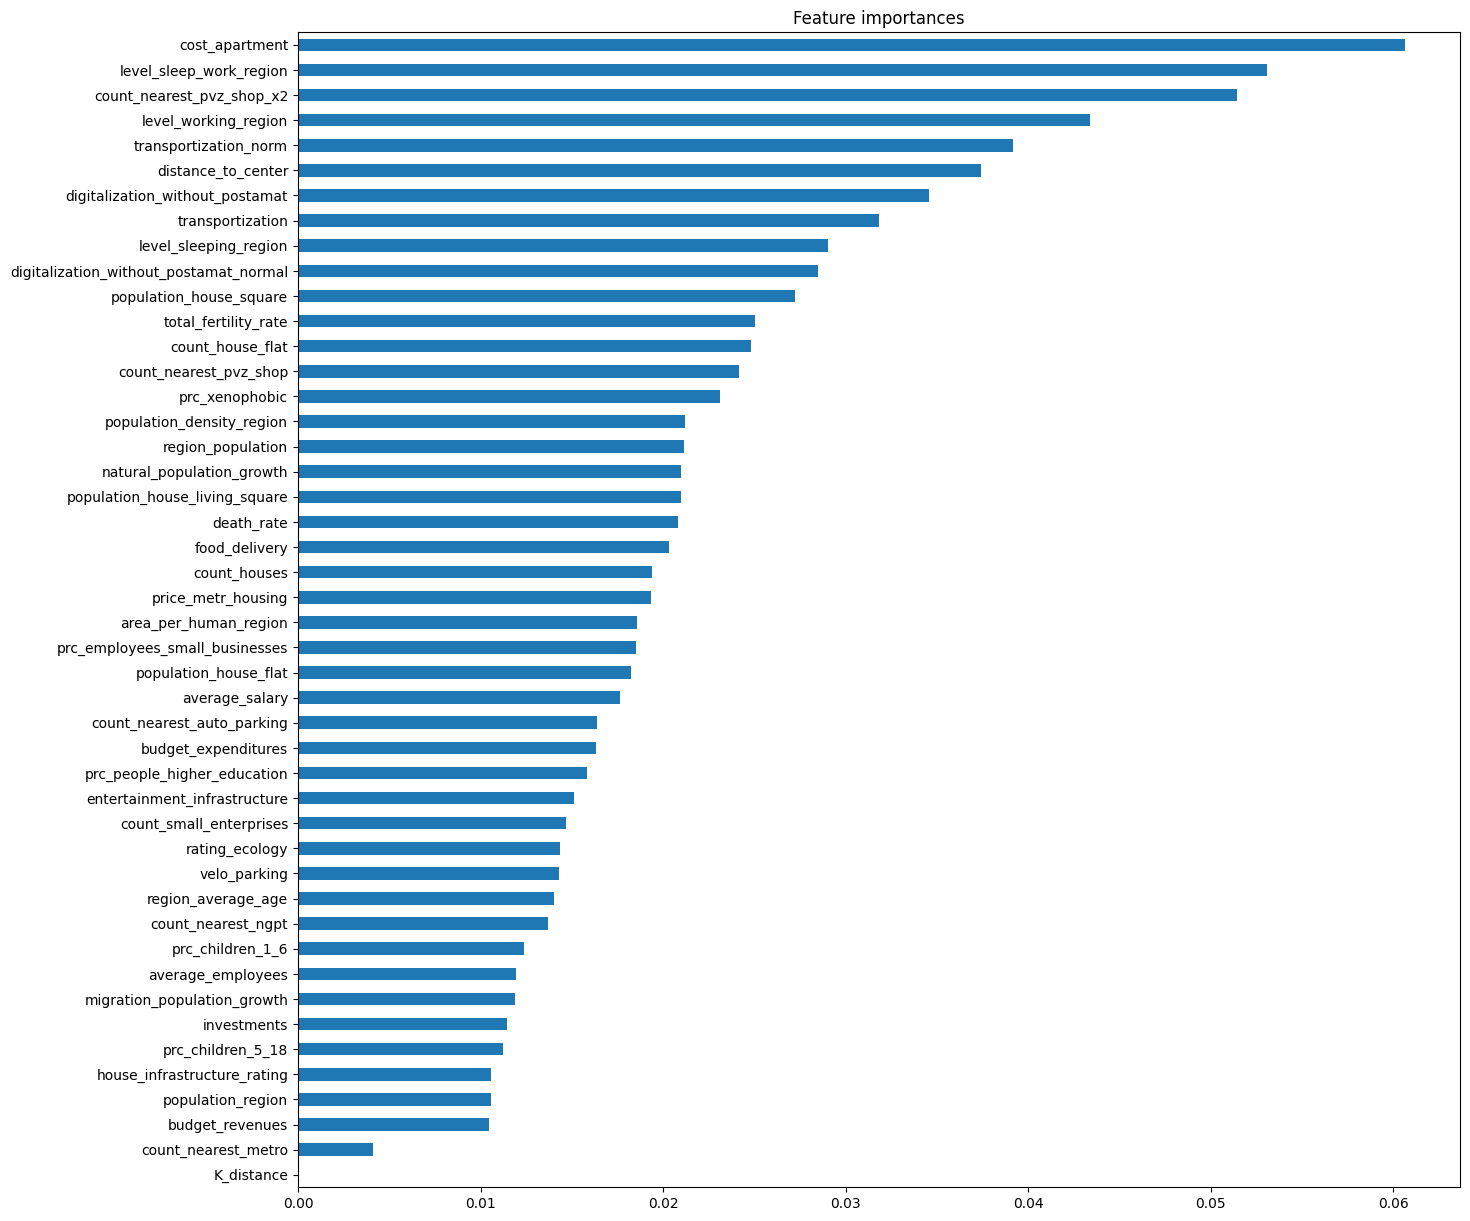

In [982]:
# Формируем важность признаков по тем моделям, где есть возможность
def get_feature_importances(model, df, num_cols):
    feature_importances = pd.Series(model.feature_importances_, index=num_cols)
    return df.append(feature_importances, ignore_index=True)

importan_features_df = pd.DataFrame()
# importan_features_df = get_feature_importances(ada_model, importan_features_df, num_cols)
# importan_features_df = get_feature_importances(gradient_model, importan_features_df, num_cols)
# importan_features_df = get_feature_importances(decis_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(forest_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(extra_model, importan_features_df, num_cols)


# Выводим сагрегированную важность признаков
importan_features_df.mean().nsmallest(x_train.shape[1]).plot(kind='barh', title="Feature importances", figsize=(15,15))

<AxesSubplot:title={'center':'Feature importances'}>

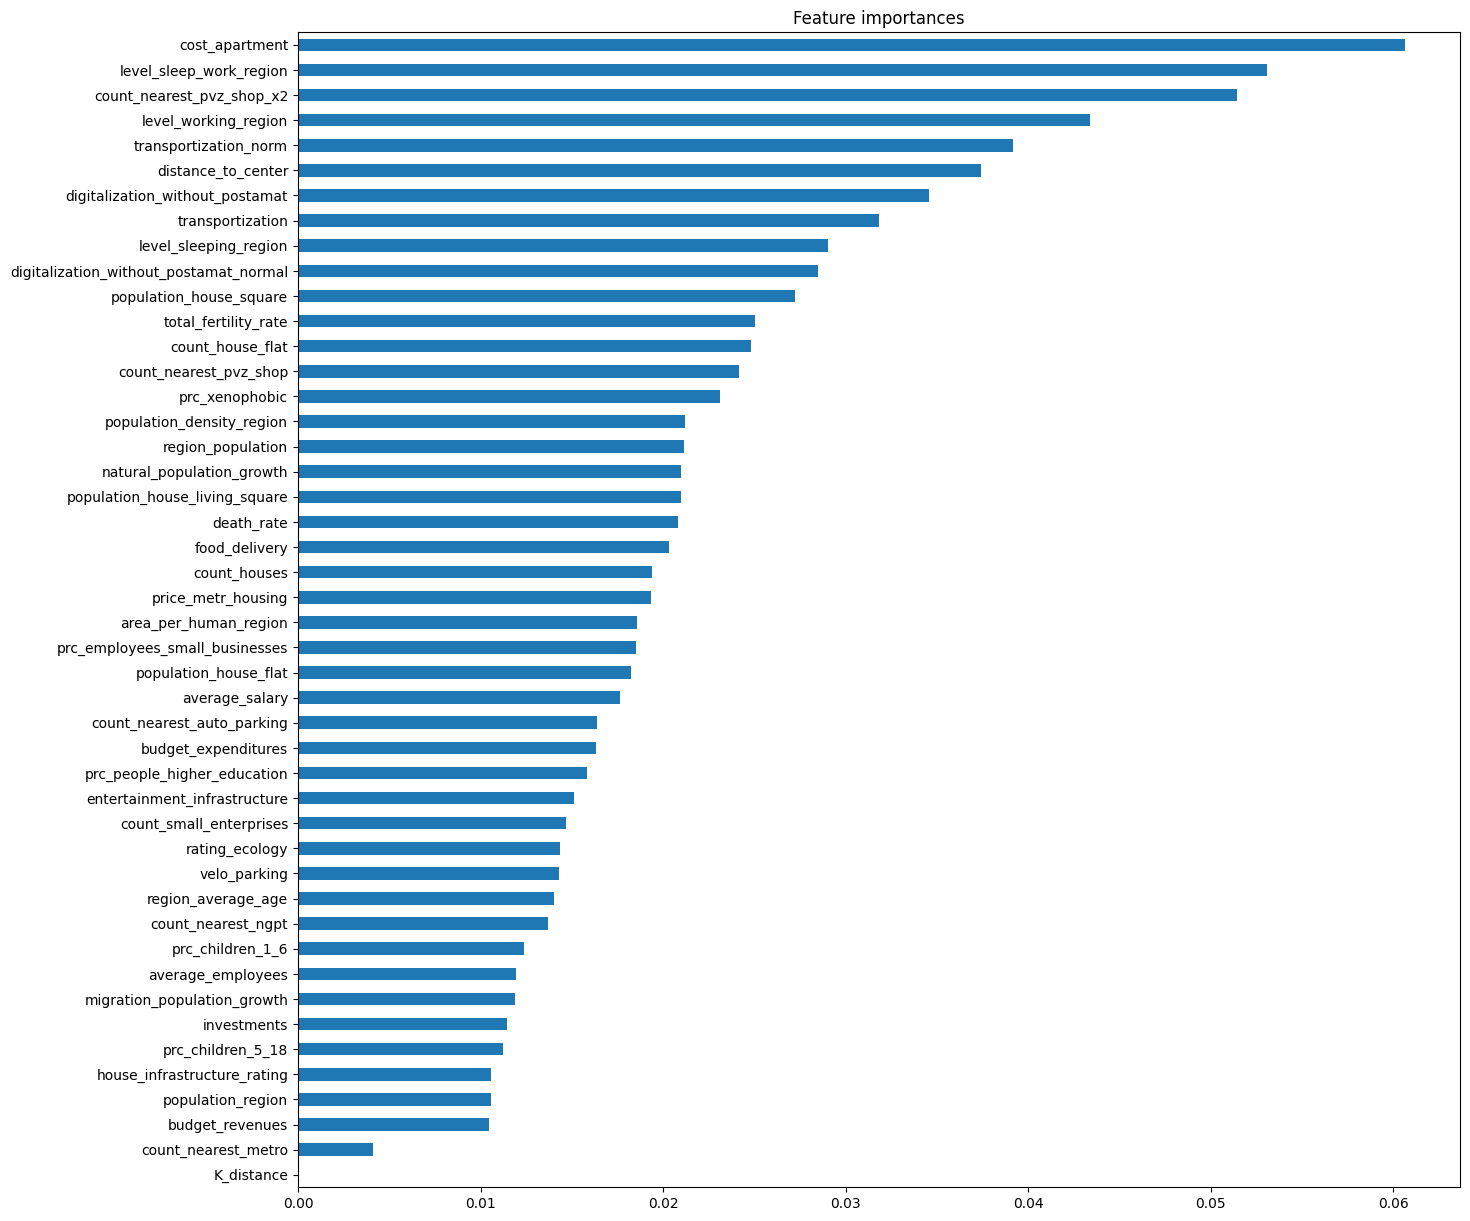

In [983]:
# Формируем важность признаков по тем моделям, где есть возможность
def get_feature_importances(model, df, num_cols):
    feature_importances = pd.Series(model.feature_importances_, index=num_cols)
    return df.append(feature_importances, ignore_index=True)

importan_features_df = pd.DataFrame()
# importan_features_df = get_feature_importances(ada_model, importan_features_df, num_cols)
# importan_features_df = get_feature_importances(gradient_model, importan_features_df, num_cols)
# importan_features_df = get_feature_importances(decis_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(forest_model, importan_features_df, num_cols)
importan_features_df = get_feature_importances(extra_model, importan_features_df, num_cols)


# Выводим сагрегированную важность признаков
importan_features_df.mean().nsmallest(x_train.shape[1]).plot(kind='barh', title="Feature importances", figsize=(15,15))

Text(0.5, 0, 'False Positive Rate')

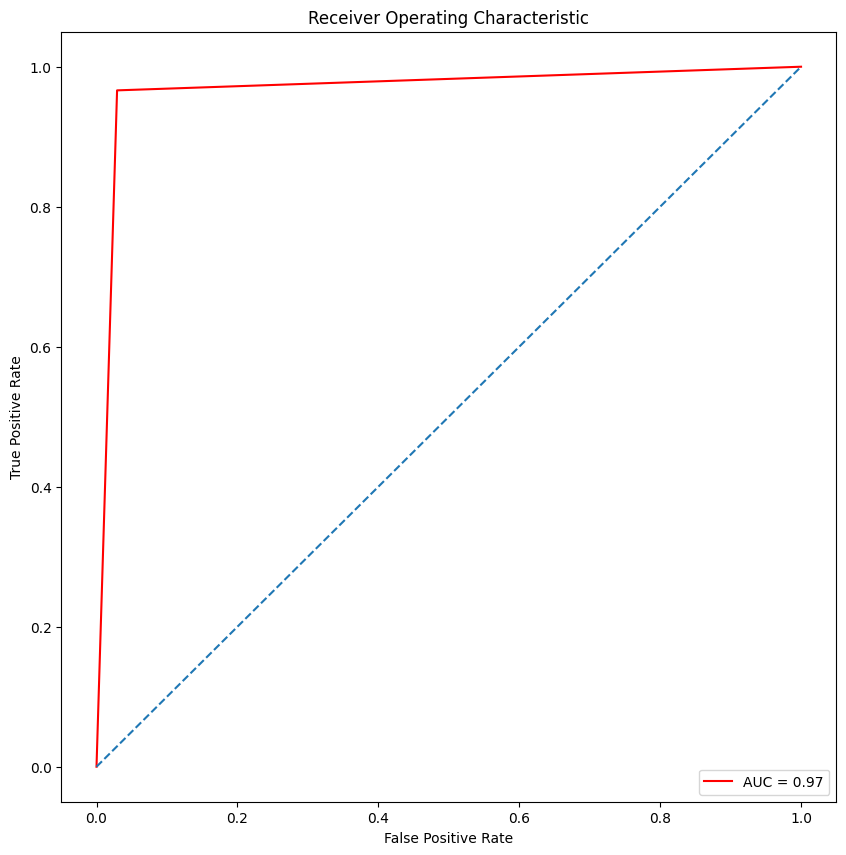

In [984]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(clear_y_val, calibrated_forest_predict_val)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Create mean predict from 7 models sklearn + model tensorflow

In [985]:
test_for_model = x_data_test[num_cols]
test_for_model


,velo_parking,digitalization_without_postamat_normal,count_nearest_ngpt,K_distance,count_small_enterprises,prc_children_1_6,population_house_flat,rating_ecology,prc_xenophobic,population_house_living_square,prc_employees_small_businesses,count_house_flat,house_infrastructure_rating,transportization_norm,transportization,digitalization_without_postamat,region_average_age,prc_children_5_18,area_per_human_region,count_nearest_pvz_shop_x2,death_rate,population_region,population_density_region,budget_revenues,count_nearest_metro,investments,population_house_square,average_salary,level_sleeping_region,count_nearest_pvz_shop,food_delivery,natural_population_growth,total_fertility_rate,level_working_region,region_population,count_houses,budget_expenditures,count_nearest_auto_parking,cost_apartment,distance_to_center,price_metr_housing,prc_people_higher_education,migration_population_growth,entertainment_infrastructure,average_employees,level_sleep_work_region
0,0,0.273949,1,0.1949,917,6.69,0,7,11.48,0,39.62,0,36,0.121269,1.95,2.700467,41.7,12.10,17.4,0,9.7,93400,7414,23881,1,578763,0,99175,19543,0,0,-3.3,6.4,80346,93400,0,22817,1,41185,6.295702,205429,48.47,7.7,85,58801,0.243236
1,0,0.298459,0,0.1949,917,6.69,99,7,11.48,65,39.62,31,36,0.003067,0.50,4.700467,41.7,12.10,17.4,8,9.7,93400,7414,23881,0,578763,80,99175,42671,3,0,-3.3,6.4,207176,93400,1,22817,1,41185,3.362210,205429,48.47,7.7,85,58801,0.205965
2,2,0.422920,3,0.1949,917,6.69,758,7,11.48,616,39.62,237,36,0.132168,3.75,13.160467,41.7,12.10,17.4,17,9.7,93400,7414,23881,1,578763,911,99175,21085,11,0,-3.3,6.4,73384,93400,2,22817,2,41185,5.590130,205429,48.47,7.7,85,58801,0.287324
3,0,0.375322,8,0.1949,917,6.69,4156,7,11.48,3148,39.62,1299,36,0.062000,10.20,7.620467,41.7,12.10,17.4,20,9.7,93400,7414,23881,0,578763,3994,99175,9168,1,1,-3.3,6.4,53401,93400,8,22817,10,41185,4.900827,205429,48.47,7.7,85,58801,0.171682
4,0,0.321400,4,0.1949,917,6.69,4156,7,11.48,3330,39.62,1298,36,0.021798,3.60,5.620467,41.7,12.10,17.4,7,9.7,93400,7414,23881,0,578763,3975,99175,34053,4,1,-3.3,6.4,103907,93400,18,22817,2,41185,4.847021,205429,48.47,7.7,85,58801,0.327726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64450,0,0.112312,0,0.1949,180,3.86,5232,30,25.89,6072,47.62,1635,14,0.000000,0.00,1.800750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,8039,156344,4595,0,0,2.9,12.5,1903,8600,6,25603,0,15556,27.449695,98557,33.05,38.4,0,568,2.414609
64451,0,0.112312,0,0.1949,180,3.86,2956,30,25.89,2897,47.62,924,14,0.000000,0.00,1.800750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,3853,156344,4615,0,0,2.9,12.5,1911,8600,4,25603,0,15556,27.401291,98557,33.05,38.4,0,568,2.414966
64452,0,0.112312,0,0.1949,180,3.86,2956,30,25.89,2897,47.62,924,14,0.000000,0.00,1.800750,41.6,5.83,11.1,1,9.6,8600,455,48422,0,159992,3853,156344,4654,0,0,2.9,12.5,1927,8600,4,25603,0,15556,27.305704,98557,33.05,38.4,0,568,2.415153
64453,0,0.112312,0,0.1949,180,3.86,3353,30,25.89,2968,47.62,1048,14,0.000000,0.00,1.800750,41.6,5.83,11.1,2,9.6,8600,455,48422,0,159992,3987,156344,4695,0,0,2.9,12.5,1945,8600,2,25603,0,15556,27.175021,98557,33.05,38.4,0,568,2.413882


In [986]:
test_for_model = x_data_test[num_cols]

tf_predict = model.predict(x_test_normalize)[:,1]

ada_predict = ada_model.predict_proba(x_test_normalize)[:,1]
gradient_predict = gradient_model.predict_proba(x_test_normalize)[:,1]
decis_predict = decis_model.predict_proba(x_test_normalize)[:,1]
forest_predict = forest_model.predict_proba(x_test_normalize)[:,1]
calibrated_forest_predict = calibrated_forest_model.predict_proba(x_test_normalize)[:,1]
extra_predict = extra_model.predict_proba(x_test_normalize)[:,1]
logler_predict = logler_model.predict_proba(x_test_normalize)[:,1]
hist_gradient_predict = hist_gradient_model.predict_proba(x_test_normalize)[:,1]
voting_predict = voting_model.predict_proba(x_test_normalize)[:,1]
stacking_predict = stacking_model.predict_proba(x_test_normalize)[:,1]



In [987]:
x_data_test.shape

(64455, 46)

In [988]:
tf_predict.shape, gradient_predict.shape, test_df.shape 

((64455,), (64455,), (64455, 63))

In [989]:
# test_df["tf_predict"] = tf_predict
test_df["ada_predict"] = ada_predict
# test_df["gradient_predict"] = gradient_predict
# test_df["decis_predict"] = decis_predict
test_df["forest_predict"] = forest_predict
# test_df["calibrated_forest_predict"] = calibrated_forest_predict
test_df["extra_predict"] = extra_predict
test_df["logler_predict"] = logler_predict
# test_df["hist_gradient_predict"] = hist_gradient_predict
test_df["voting_predict"] = voting_predict
# test_df["stacking_predict"] = stacking_predict

# # test_df["ensemble_predict"] = test_df[["tf_predict", "ada_predict", "gradient_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1)
# test_df["ensemble_predict"] = test_df[["ada_predict", "gradient_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1)
# test_df["ensemble_predict_2"] = test_df[["ada_predict", "calibrated_forest_predict", "forest_predict", "extra_predict", "logler_predict"]].mean(axis=1)
# test_df["ensemble_predict_3"] = test_df[["calibrated_forest_predict", "forest_predict", "extra_predict", "logler_predict"]].mean(axis=1)
# test_df["ensemble_predict_5"] = test_df[["forest_predict", "extra_predict", "logler_predict", "voting_predict"]].mean(axis=1)
# test_df["ensemble_predict_6"] = test_df[["forest_predict", "extra_predict", "logler_predict", "voting_predict", "ada_predict"]].mean(axis=1)
# test_df["ensemble_predict_7"] = test_df[[ "extra_predict", "logler_predict", "voting_predict"]].mean(axis=1)

# test_df["ensemble_boost"] = test_df[[ "extra_predict", "logler_predict", "voting_predict"]].mean(axis=1)


# # Ансамбль + Бустинг + С.Лес
# test_df["ensemble_boosting"] = test_df[["forest_predict", "extra_predict", "logler_predict", "voting_predict", "ada_predict"]].mean(axis=1)
# # Ансамбль + ЛогРег
# test_df["ensemble_logreg"] = test_df[["extra_predict", "logler_predict", "voting_predict"]].mean(axis=1)
# # Бустинг + Случайный Лес
# test_df["boosting_forest"] = test_df[["ada_predict", "calibrated_forest_predict", "forest_predict", "extra_predict", "logler_predict"]].mean(axis=1)
# # Ансамбль
# test_df["voting_ensemble"] = voting_predict
# # Стекинг
# test_df["stacking"] = stacking_predict
# # Бустинг
# test_df["ada_boosting"] = voting_predict
# # Нейронная сеть (Критично)
# test_df["tensorflow"] = tf_predict


min_max_scaler = MinMaxScaler()
# Основная модель (Ансамбль + Бустинг + С.Лес)
test_df["ensemble_predict"] = test_df[["forest_predict", "extra_predict", "logler_predict", "voting_predict", "ada_predict"]].mean(axis=1)
# Основная модель + Отсутсвие постаматов
test_df["ensemble_predict_void_postamats"] = test_df["ensemble_predict"] - pd.Series(min_max_scaler.fit_transform(test_df["count_nearest_postamats"].values.reshape(-1, 1))[:,0])
test_df.loc[test_df["ensemble_predict_void_postamats"] < 0, "ensemble_predict_void_postamats"] = 0
# Основная модель + Перевод конкурентов
test_df["ensemble_predict_cannibalism_postamats"] = test_df["ensemble_predict"] + pd.Series(min_max_scaler.fit_transform(test_df["covering_postamats"].values.reshape(-1, 1))[:,0])
# Ансамбль + ЛогРег
test_df["ensemble_logreg"] = test_df[["extra_predict", "logler_predict", "voting_predict"]].mean(axis=1)
# Стекинг
test_df["stacking"] = stacking_predict
# Нейронная сеть (0/1)
test_df["tensorflow"] = tf_predict


predicts_columns = ["ensemble_predict", "ensemble_logreg", "stacking", "tensorflow", "ensemble_predict_void_postamats", "ensemble_predict_cannibalism_postamats"]
test_df


,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,okato,prc_children_1_6,region_average_age,prc_people_higher_education,count_nearest_postamats,count_nearest_postamats_x2,count_nearest_pvz,count_nearest_pvz_x2,count_nearest_pvz_shop,count_nearest_pvz_shop_x2,count_competitor_pvz_postamat,count_competitor_pvz_postamat_x2,food_delivery,velo_parking,digitalization,digitalization_without_postamat_normal,...,rating_ecology,entertainment_infrastructure,house_infrastructure_rating,prc_xenophobic,area_per_human_region,population_density_region,population_region,death_rate,total_fertility_rate,prc_children_5_18,migration_population_growth,natural_population_growth,budget_expenditures,budget_revenues,ada_predict,forest_predict,extra_predict,logler_predict,voting_predict,ensemble_predict,ensemble_predict_void_postamats,ensemble_predict_cannibalism_postamats,ensemble_logreg,stacking,tensorflow
0,Постамат,"Леруа Мерлен, постамат","проспект Лихачёва, 15",37.646076,55.699468,NaN,0.1949,6.295702,даниловский,45296559000,6.69,41.7,48.47,2,2,0,0,0,0,2,2,0,0,0.289602,0.273949,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.483495,0.1,0.3,0.050232,0.208634,0.228472,0.157044,0.248472,0.186288,0.043627,3.650787e-07
1,Постамат,"OZON box, автоматизированный пункт выдачи","1-й Кожевнический переулок, 4",37.646195,55.727633,NaN,0.1949,3.362210,даниловский,45296559000,6.69,41.7,48.47,2,10,1,1,3,8,6,19,0,0,0.314111,0.298459,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.465211,0.2,0.3,0.009742,0.210364,0.237064,0.165635,0.297064,0.173369,0.063333,3.934239e-07
2,Постамат,"OZON box, Постамат №3406","Ленинская Слобода, 19 ст2",37.655232,55.707906,NaN,0.1949,5.590130,даниловский,45296559000,6.69,41.7,48.47,12,15,6,7,11,17,29,39,0,2,0.516833,0.422920,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.526637,0.8,0.7,0.953323,0.770036,0.749999,0.321428,1.039999,0.807786,0.937315,9.999980e-01
3,Постамат,"Cainiao, постамат","Большая Тульская, 2",37.620965,55.710139,NaN,0.1949,4.900827,даниловский,45296559000,6.69,41.7,48.47,8,11,5,6,1,20,14,37,1,0,0.437931,0.375322,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.517103,0.9,0.9,0.997215,0.857423,0.834348,0.548634,0.974348,0.918213,0.986813,9.999995e-01
4,Постамат,"Cainiao, постамат","Серпуховский Вал улица, 17 к1",37.613230,55.710821,NaN,0.1949,4.847021,даниловский,45296559000,6.69,41.7,48.47,5,8,1,2,4,7,10,17,1,0,0.360531,0.321400,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.517202,0.7,0.7,0.272278,0.618723,0.561641,0.383069,0.661641,0.530334,0.871612,8.721337e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64450,Многоквартирный дом,9109357,"ул. Синявинская, д. 11, к. 11",37.348814,55.947565,NaN,0.1949,27.449695,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0.112312,0.112312,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.472721,0.0,0.0,0.017572,0.100012,0.118061,0.118061,0.118061,0.039195,0.005047,7.951972e-07
64451,Многоквартирный дом,9109496,"ул. Синявинская, д. 11, к. 12",37.349326,55.947238,NaN,0.1949,27.401291,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0.112312,0.112312,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.458924,0.0,0.0,0.013254,0.099458,0.114327,0.114327,0.114327,0.037571,0.005008,7.867390e-07
64452,Многоквартирный дом,9107604,"ул. Синявинская, д. 11, к. 13",37.350359,55.946602,NaN,0.1949,27.305704,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0.112312,0.112312,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.458924,0.0,0.0,0.013222,0.099452,0.114320,0.114320,0.114320,0.037558,0.005008,7.878855e-07
64453,Многоквартирный дом,9107605,"ул. Синявинская, д. 11, к. 15",37.3492

In [990]:
test_df[predicts_columns].describe()

,ensemble_predict,ensemble_logreg,stacking,tensorflow,ensemble_predict_void_postamats,ensemble_predict_cannibalism_postamats
count,64455.000000,64455.000000,64455.000000,6.445500e+04,64455.000000,64455.000000
mean,0.424394,0.420379,0.372718,3.358045e-01,0.347081,0.472708
std,0.231789,0.277866,0.397071,4.502483e-01,0.202115,0.264255
min,0.060715,0.018692,0.004575,2.500643e-07,0.000000,0.060715
25%,0.226548,0.174063,0.015171,2.969290e-06,0.183865,0.249945
50%,0.391746,0.384626,0.151236,1.455117e-03,0.323639,0.430077
75%,0.605395,0.643730,0.830607,9.885573e-01,0.504458,0.668307
max,0.892120,0.969457,0.995213,9.999998e-01,0.887380,1.659478


In [991]:
# # scaler = MinMaxScaler()
# # src_values = test_df["count_nearest_postamats"].values
# # min_max_value = scaler.fit_transform(test_df["count_nearest_postamats"].values.reshape(1, -1))

# # src_values[:20], min_max_value[:20]


# # from sklearn.preprocessing import MinMaxScaler, StandardScaler
# # scaler = MinMaxScaler((0,1))
# # # scaler = StandardScaler()

# # # test3 = test3[(test3["count_nearest_postamats_x2"]>=2)]
# # # test_df["count_nearest_postamats"].values, 
# # # pd.Series(scaler.fit_transform(test_df["count_nearest_postamats"].values.reshape(-1, 1)))

# # # test_df["covering_postamats"]
# # # pd.Series(scaler.fit_transform(test_df["count_nearest_postamats"].values.reshape(-1, 1)))
# # pd.Series(scaler.fit_transform(test_df["covering_postamats"].values.reshape(-1, 1))[:,0])
# test_df[predicts_columns].describe()

In [992]:
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["tf_predict"] = tf_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["gradient_predict"] = gradient_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["decis_predict"] = decis_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["forest_predict"] = forest_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["calibrated_forest_predict"] = calibrated_forest_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["extra_predict"] = extra_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["logler_predict"] = logler_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["hist_gradient_predict"] = hist_gradient_predict
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]["voting_predict"] = voting_predict
# test_df = test_df.fillna(0)
# # test_df["ensemble_predict"] = test_df[["tf_predict", "gradient_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1)

# # test_df["ensemble_predict"] = test_df[["tf_predict", "gradient_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1)

# test_df
# test_df[test_df["population_house_living_square"] > COUNT_POPULATION]
# x_data_test[x_data_test["population_house_living_square"] > COUNT_POPULATION]


In [993]:
test_df["type"].unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
       'Hexagon_9', 'Многоквартирный дом'], dtype=object)

In [994]:
test_df["transportization"].describe()

count    64455.000000
mean         2.611570
std          1.917567
min          0.000000
25%          1.300000
50%          2.300000
75%          3.750000
max         17.400000
Name: transportization, dtype: float64

In [1039]:
list_objects = ['Киоск', 'Дом культуры', 'МФЦ', 'Библиотека', 'Многоквартирный дом']
# list_objects = ['Многоквартирный дом']
list_objects = ['Постамат']
# list_objects = ['Киоск', 'Дом культуры', 'МФЦ', 'Библиотека']
# test_df["digitalization"] = pd.Series(MinMaxScaler((0,10)).fit_transform(test_df["digitalization"].values.reshape(-1, 1))[:,0])
# test_df["transportization"] = pd.Series(MinMaxScaler((0,10)).fit_transform(test_df["transportization"].values.reshape(-1, 1))[:,0])


df_Hexagon = test_df[(test_df["type"] == "Hexagon_9")]
df_Hexagon['geometry'] = geopandas.GeoSeries.from_wkt(df_Hexagon['geometry'])
df_Object = test_df[test_df["type"].isin(list_objects)]


df_Hexagon.shape, df_Object.shape

D:\_Work\_Projects\_Conda\School\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


((10381, 74), (6588, 74))

In [1033]:
test_df["type"].unique()

array(['Постамат', 'Киоск', 'Дом культуры', 'МФЦ', 'ПВЗ-Крупные сети',
       'ПВЗ', 'ПВЗ-Интернет Магазина', 'Доставка еды', 'Библиотека',
       'Hexagon_9', 'Многоквартирный дом'], dtype=object)

In [1034]:
test_df[test_df["type"] == "ПВЗ-Интернет Магазина"].shape, test_df[test_df["type"] == "ПВЗ-Крупные сети"].shape, test_df[test_df["type"] == "ПВЗ"].shape

((4000, 74), (2643, 74), (6336, 74))

In [1040]:
# Сохраняем данные о предсказаниях
geo_predict_df_Object = geopandas.GeoDataFrame(
    df_Object, geometry=geopandas.points_from_xy(df_Object.lon, df_Object.lat))
geo_predict_df_Object.to_file(PATH_DATASET_RESULT + "postamat_predict_objects.json", driver="GeoJSON")

In [1025]:
t_objects = geopandas.read_file(PATH_DATASET_RESULT  + "predict_hexagon_9.json", driver="GeoJSON") 
# # set(geo_predict_df_Object.columns) == set(t_objects.columns), set(geo_predict_df_Object.columns) - set(t_objects.columns)
# geo_predict_df_Object.columns
t_objects.columns

Index(['type', 'name', 'geometry_name', 'lon', 'lat', 'K_distance',
       'distance_to_center', 'normalize_name', 'okato', 'prc_children_1_6',
       'region_average_age', 'prc_people_higher_education',
       'count_nearest_postamats', 'count_nearest_postamats_x2',
       'count_nearest_pvz', 'count_nearest_pvz_x2', 'count_nearest_pvz_shop',
       'count_nearest_pvz_shop_x2', 'count_competitor_pvz_postamat',
       'count_competitor_pvz_postamat_x2', 'food_delivery', 'velo_parking',
       'digitalization', 'digitalization_without_postamat_normal',
       'digitalization_without_postamat', 'covering_postamats',
       'count_nearest_metro', 'count_nearest_ngpt',
       'count_nearest_auto_parking', 'transportization_norm',
       'transportization', 'level_working_region', 'level_sleeping_region',
       'level_sleep_work_region', 'count_houses', 'count_house_flat',
       'population_house_flat', 'population_house_square',
       'population_house_living_square', 'okrug', 'region_p

In [1026]:
set(t_objects.columns) == set(geo_predict_df_Object.columns) 

True

In [997]:
# test_df["tf_predict"] = [1 if x[1] > x[0] else 0 for x in tf_predict ]
# # test_df["tf_predict"] = tf_predict

# test_df["gradient_predict"] = gradient_predict
# test_df["decis_predict"] = decis_predict
# test_df["forest_predict"] = forest_predict
# test_df["extra_predict"] = extra_predict
# test_df["logler_predict"] = logler_predict
# test_df["hist_gradient_predict"] = hist_gradient_predict
# test_df["ensemble_predict"] = test_df[["tf_predict", "gradient_predict", "decis_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1)
# # test_df["ensemble_predict"] = np.where(test_df[["tf_predict", "gradient_predict", "decis_predict", "forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict"]].mean(axis=1) >= 0.5, 1, 0)

In [998]:
# test_df = test_df[~(test_df["type"] == "Спорт")]
# df_Hexagon = test_df[(test_df["type"] == "Hexagon")]
# df_Object = test_df[~(test_df["type"] == "Hexagon")]
# df_Hexagon.shape, df_Object.shape

In [999]:
print(test_df[(test_df["type"] == "Hexagon_9")].shape )
# test_df[(test_df["type"] == "Hexagon_9")].head(3)

(10381, 74)


In [1010]:
# df_Hexagon[df_Hexagon["population_house_living_square"]< 100]["extra_predict"] = 0
# df_Hexagon[df_Hexagon["extra_predict"] == 0]
# df_Hexagon.loc[df_Hexagon["population_house_living_square"]< 100, "extra_predict"] = 0
# df_Hexagon[df_Hexagon["population_house_living_square"]< 100]["extra_predict"].shape, df_Hexagon[df_Hexagon["extra_predict"] == 0].shape
# df_Hexagon.loc[(df_Hexagon["population_house_living_square"]< 300)&(df_Hexagon["count_houses"] <= 1)&(df_Hexagon["count_competitor_pvz_postamat_x2"] <=2)].iloc[:,20:]

# predicts_columns = ["tf_predict", "ada_predict", "gradient_predict", "decis_predict", "forest_predict", "calibrated_forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict", "voting_predict", "ensemble_predict"]
# predicts_columns = ["stacking_predict", "tf_predict", "ada_predict", "gradient_predict", "decis_predict", "forest_predict", "calibrated_forest_predict", "extra_predict", "logler_predict", "hist_gradient_predict", "voting_predict", "ensemble_predict", "ensemble_predict_2", "ensemble_predict_3", "ensemble_predict_4", "ensemble_predict_5", ]
# predicts_columns =["stacking_predict", "voting_predict", "ensemble_predict", "ensemble_predict_2", "ensemble_predict_3", "ensemble_predict_5", "ensemble_predict_6", "ensemble_predict_7", ]
df_Hexagon.loc[(df_Hexagon["count_houses"] <= 2)&(df_Hexagon["count_competitor_pvz_postamat_x2"] <=2), predicts_columns] = 0
# df_Hexagon.loc[(df_Hexagon["count_houses"] <= 2)&(df_Hexagon["count_competitor_pvz_postamat_x2"] <=2)]

D:\_Work\_Projects\_Conda\School\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
for column in predicts_columns:
    print(column)
    df_Hexagon[column].hist()
    plt.show()
#     df_Hexagon["stacking_predict"].hist()


In [1002]:
df_Hexagon.shape

(10381, 74)

In [1011]:
# Сохраняем данные о предсказаниях
geo_predict_df_Object = geopandas.GeoDataFrame(
    df_Object, geometry=geopandas.points_from_xy(df_Object.lon, df_Object.lat))


In [1012]:
# Нормируем данные по цифровизации и транспортной досутпности
# geo_predict_df_Object["digitalization"] = pd.Series(MinMaxScaler((0,10)).fit_transform(geo_predict_df_Object["digitalization"].values.reshape(-1, 1))[:,0])
# test_df["digitalization"] = pd.Series(MinMaxScaler((0,10)).fit_transform(test_df["digitalization"].values.reshape(-1, 1))[:,0])
# test_df["transportization"] = pd.Series(MinMaxScaler((0,10)).fit_transform(test_df["transportization"].values.reshape(-1, 1))[:,0])

# geo_predict_df_Object["digitalization"].describe()
geo_predict_df_Object[["transportization", "digitalization"]].describe()

,transportization,digitalization
count,1112.00000,1112.000000
mean,4.24384,0.343594
std,2.32863,0.091534
min,0.00000,0.076720
25%,2.60000,0.282437
50%,3.90000,0.334103
75%,5.55000,0.403099
max,14.80000,0.708217


In [1015]:
# t_objects = geopandas.read_file(PATH_DATASET_RESULT  + "3_result/" + "predict_objects.json", driver="GeoJSON") 
# # set(geo_predict_df_Object.columns) == set(t_objects.columns), set(geo_predict_df_Object.columns) - set(t_objects.columns)
# geo_predict_df_Object.columns

In [1006]:
# Сохраняем данные о предсказаниях
geo_predict_df_Hexagon = geopandas.GeoDataFrame(
    df_Hexagon, geometry="geometry")
geo_predict_df_Hexagon.shape

(10381, 74)

In [ ]:
t_objects = geopandas.read_file(PATH_DATASET_RESULT  + "3_result/" + "predict_hexagon_9.json", driver="GeoJSON") 
set(geo_predict_df_Hexagon) == set(t_objects.columns), set(geo_predict_df_Hexagon) - set(t_objects.columns)


In [ ]:
# geo_predict_df_Object.to_file(PATH_DATASET_RESULT + "kiosk_predict_objects.json", driver="GeoJSON")

In [1007]:
geo_predict_df_Object.to_file(PATH_DATASET_RESULT + "predict_only_house_objects.json", driver="GeoJSON") 

In [923]:
geo_predict_df_Hexagon.to_file(PATH_DATASET_RESULT + "predict_hexagon_9.json", driver="GeoJSON") 

In [924]:
# Формируем Гексагоны 7 и 8
df_Hexagon_8 = pd.read_csv(PATH_DATASET_RESULT + "df_Hexagon_8.csv", sep=";").iloc[:,2:]
df_Hexagon_8['geometry'] = geopandas.GeoSeries.from_wkt(df_Hexagon_8['geometry'])
geo_predict_df_Hexagon_8 = geopandas.GeoDataFrame(
     df_Hexagon_8, geometry="geometry")

df_Hexagon_7 = pd.read_csv(PATH_DATASET_RESULT + "df_Hexagon_7.csv", sep=";").iloc[:,2:]
df_Hexagon_7['geometry'] = geopandas.GeoSeries.from_wkt(df_Hexagon_7['geometry'])
geo_predict_df_Hexagon_7 = geopandas.GeoDataFrame(
     df_Hexagon_7, geometry="geometry")

In [925]:
%%time
# Расчет средних значений предсказаний по гексагонам 
def get_mean_predicts_by_parnet_hexagon(df, x, predicts_columns):
    find_hexagons = df[df["geometry_name"] == x["name"]]
    for column in predicts_columns:
        x[column] = find_hexagons[column].mean()
#     x["gradient_predict"] = find_hexagons["gradient_predict"].mean()
#     x["decis_predict"] = find_hexagons["decis_predict"].mean()
#     x["forest_predict"] = find_hexagons["forest_predict"].mean()
#     x["extra_predict"] = find_hexagons["extra_predict"].mean()
#     x["logler_predict"] = find_hexagons["logler_predict"].mean()
#     x["hist_gradient_predict"] = find_hexagons["hist_gradient_predict"].mean()
# #     x["calibrated_forest_predict"] = find_hexagons["calibrated_forest_predict"].mean()
#     x["ensemble_predict"] = find_hexagons["ensemble_predict"].mean()
    return x

# Ищем гексагоны, которые входят в искомый гексагон более высокого  уровня
geo_predict_df_Hexagon_8 = geo_predict_df_Hexagon_8.apply(lambda x: get_mean_predicts_by_parnet_hexagon(geo_predict_df_Hexagon, x, predicts_columns), axis=1)
geo_predict_df_Hexagon_8.to_file(PATH_DATASET_RESULT + "predict_hexagon_8.json", driver="GeoJSON") 
geo_predict_df_Hexagon_8.shape

Wall time: 13.4 s


(1481, 79)

In [926]:
%%time
# Ищем гексагоны, которые входят в искомый гексагон более высокого уровня
geo_predict_df_Hexagon_7 = geo_predict_df_Hexagon_7.apply(lambda x: get_mean_predicts_by_parnet_hexagon(geo_predict_df_Hexagon_8, x, predicts_columns), axis=1)
geo_predict_df_Hexagon_7.to_file(PATH_DATASET_RESULT + "predict_hexagon_7.json", driver="GeoJSON") 
geo_predict_df_Hexagon_7.shape

Wall time: 1.8 s


(215, 79)

In [927]:
PATH_DATASET_RESULT

'datasets/result/'

In [686]:
set(geo_predict_df_Hexagon.columns) - set(geo_predict_df_Hexagon_7.columns)

{'ada_predict',
 'extra_predict',
 'forest_predict',
 'logler_predict',
 'voting_predict'}

In [687]:
geo_predict_df_Hexagon_7

,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,okato,prc_children_1_6,region_average_age,prc_people_higher_education,count_nearest_postamats,count_nearest_postamats_x2,count_nearest_pvz,count_nearest_pvz_x2,count_nearest_pvz_shop,count_nearest_pvz_shop_x2,count_competitor_pvz_postamat,count_competitor_pvz_postamat_x2,food_delivery,food_delivery_x2,velo_parking,velo_parking_x2,...,prc_employees_small_businesses,count_small_enterprises,investments,price_metr_housing,cost_apartment,rating_ecology,entertainment_infrastructure,house_infrastructure_rating,prc_xenophobic,area_per_human_region,population_density_region,population_region,death_rate,total_fertility_rate,prc_children_5_18,migration_population_growth,natural_population_growth,budget_expenditures,budget_revenues,ensemble_predict,ensemble_logreg,stacking,tensorflow,ensemble_predict_void_postamats,ensemble_predict_cannibalism_postamats
0,Hexagon_7,8711aa783ffffff,8611aa787ffffff,37.638720,55.703192,"POLYGON ((37.61943 55.69787, 37.63614 55.69048...",1.36437,5.787263,даниловский,45296559000,6.69,41.7,48.47,46,230,19,87,74,245,139,562,6,35,5,32,...,39.62,917,578763,205429,41185,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.152712,0.106186,0.058382,1.046070e-01,0.128102,0.176998
1,Hexagon_7,8711aa78effffff,8611aa78fffffff,37.660611,55.721221,"POLYGON ((37.64131 55.71590, 37.65802 55.70851...",1.36437,4.445445,даниловский,45296559000,6.69,41.7,48.47,78,261,19,98,66,326,163,685,8,41,12,54,...,39.62,917,578763,205429,41185,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.348588,0.326806,0.291866,3.440931e-01,0.296110,0.378996
2,Hexagon_7,8711aa681ffffff,8611aa687ffffff,37.876885,55.708530,"POLYGON ((37.85752 55.70324, 37.87422 55.69581...",1.36437,16.883303,косино-ухтомский,45263573000,9.85,34.1,54.08,43,218,16,50,11,50,70,318,6,33,8,23,...,64.14,133,26,138365,25385,31,42,60,20.50,18.4,5421,81200,4.5,12.9,15.33,13.2,8.4,24009,30301,0.249694,0.223356,0.175995,2.168276e-01,0.230137,0.260742
3,Hexagon_7,8711aa685ffffff,8611aa687ffffff,37.840822,55.710673,"POLYGON ((37.82147 55.70538, 37.83817 55.69795...",1.36437,14.657507,косино-ухтомский,45263573000,9.85,34.1,54.08,44,191,16,65,18,67,78,323,6,25,13,37,...,64.14,133,26,138365,25385,31,42,60,20.50,18.4,5421,81200,4.5,12.9,15.33,13.2,8.4,24009,30301,0.167241,0.130170,0.097386,1.060789e-01,0.144646,0.177241
4,Hexagon_7,8711aa688ffffff,8611aa68fffffff,37.935017,55.724376,"POLYGON ((37.91563 55.71910, 37.93233 55.71165...",1.36437,20.025477,косино-ухтомский,45263573000,9.85,34.1,54.08,4,99,2,33,0,17,6,149,2,22,0,12,...,64.14,133,26,138365,25385,31,42,60,20.50,18.4,5421,81200,4.5,12.9,15.33,13.2,8.4,24009,30301,0.006551,0.004250,0.000537,6.006363e-09,0.006551,0.006551
5,Hexagon_7,8711aa6aaffffff,8611aa6afffffff,37.862842,55.728682,"POLYGON ((37.84347 55.72339, 37.86018 55.71596...",1.36437,15.476847,косино-ухтомский,45263573000,9.85,34.1,54.08,43,227,16,62,9,50,68,339,4,27,12,56,...,64.14,133,26,138365,25385,31,42,60,20.50,18.4,5421,81200,4.5,12.9,15.33,13.2,8.4,24009,30301,0.275691,0.269710,0.264221,3.422668e-01,0.240997,0.292263
6,Hexagon_7,8711aa788ffffff,8611aa78fffffff,37.682524,55.739249,"POLYGON ((37.66320 55.73393, 37.67992 55.72654...",1.36437,4.228122,таганский,45286580000,6.20,41.9,57.05,81,217,27,86,71,280,179,583,10,38,19,59,...,33.04,666,268013,221993,42105,12,96,93,14.49,20.8,15099,120500,9.6,10.4,10.94,8.9,0.8,25695,24871,0.468392,0.465443,0.486897,4.599073e-01,0.397693,0.509413
7,Hexagon_7,8711aa78cffffff,8611aa78fffffff,37.646482,55.741329,"POLYGON ((37.62717 55.73601, 37.64389 55.72862...",1.36437,2.163589,таганский,45286580000,6.20,41.9,57.05,62,243,35,125,92,336,189,704,16,66,19,79,...,33.04,666,268013,221993,42105,12,96,93,14.49,20.8,15099,120500,9.6,10.4,10.94,8.9,0.8,25695,24871,0.247187,0.215540,0.146885,1.857894e-01,0.211397,0.286983
8,Hexagon_7,8711aa781ffffff,8611aa787ffffff,37.624589,55.723297,"POLYGON ((37.60529 55.71798, 37.62201 

In [688]:
# geo_predict_df_Hexagon

In [689]:
dict_name_columns = {"type": [1, 0, "Тип объекта"], 
"name": [1, 0, "Наименование"],
"geometry_name": [1, 0, "Наименование"],
"lon": [0, 0, "Долгота"],
"lat": [0, 0, "Широта"],
"distance_to_center": [1, 1, "Расстояние до центра"],
"normalize_name": [1, 1, "Район"],
"okato": [1, 1, "ОКАТО"],
"region_average_age": [1, 1, "Средний возраст в районе"], 
"count_nearest_postamats": [1, 1, "Постаматов рядом"],
"count_nearest_pvz": [1, 1, "ПВЗ рядом"],
"velo_parking": [1, 1, "Велопарковки"],
"digitalization": [1, 1, "Уровень цифровизации"],
"count_nearest_ngpt": [1, 1, "Остановки рядом"],
"count_nearest_auto_parking": [1, 1, "Автомобильные парковки"],
"transportization": [1, 1, "Уровень транспортной доступности"],
"count_house_flat": [1, 1, "Количество семей"],
"population_house_living_square": [1, 1, "Плотность населения"],
"prc_xenophobic": [1, 1, "Процент арендотателей-ксенофобов"],
"geometry": [0, 0, "Полигон"], 
"K_distance": [0, 0, "Радиус поиска"],
"count_nearest_postamats_x2": [0, 0, "Кол-во постаматов в радиусе x2"],
"count_nearest_postamats_x3": [0, 0, "Кол-во постаматов в радиусе x3"],
"count_nearest_pvz_shop": [0, 0, "кол-во ПВЗ Частных Интернет магазинов"],
"food_delivery": [0, 0, "кол-во мест размещения доставки еды"],
"digitalization_without_postamat": [0, 0, "Уровень цифровизации без учета постаматов"],
"covering_postamats": [0, 0, "Уровень покрытия пастоматами и ПВЗ"],
"count_nearest_metro": [0, 0, "Кол-во станций метро рядом"],
"level_sleep_work_region": [0, 0, "Отношение ройна (сапльный/рабочий)"],
"level_working_region": [0, 0, "Показатель что район рабочий"],
"level_sleeping_region": [0, 0, "Показатель что район спальный"],
"population_house_flat": [0, 0, "Плотность населения по жилой площади по кол-ву квартир"],
"population_house_square": [0, 0, "Плотность населения по общей площади"],
"region_population": [0, 0, "Статистика плотности населения по району"],
"average_salary": [0, 0, "Средний доход в районе"],
"average_employees": [0, 0, "Среднесписочная численность работников"],
"prc_employees_small_businesses": [0, 0, "Процент работающих в малом и среднем бизнесе"],
"count_small_enterprises": [0, 0, "Количество малых и средних предприятий"],
"investments": [0, 0, "Инвестиции в основной капитал"],
"price_metr_housing": [0, 0, "Цена за квадратный метр жилья: медианная"],
"cost_apartment": [0, 0, "Стоимость съема квартиры"],
"rating_ecology": [0, 0, ", Рейтинг районов по экологии"],
"entertainment_infrastructure": [0, 0, "Рейтинг развлекательной инфраструктуры района"],
"house_infrastructure_rating": [0, 0, "Рейтинг жилой инфраструктуры"],
"area_per_human_region": [0, 0, "Площадь жилых помещений на 1 жителя по району"],
"population_density_region": [0, 0, "Плотность населения по райноу"],
"population_region": [0, 0, "Численность населения по райноу"],
"prc_people_higher_education": [0, 0, "Процент людей с высшим образованием (также над к уровню цифровизации добавлять)"],
"death_rate": [0, 0, "Общий коэффициент смертности"],
"total_fertility_rate": [0, 0, "Общий коэффициент рождаемости"],
"prc_children_1_6": [0, 0, "Доля детей 1–6 лет"],
"prc_children_5_18": [0, 0, "Доля детей 5–18 лет"],
"migration_population_growth": [0, 0, "Миграционный прирост населения"],
"natural_population_growth": [0, 0, "Естественный прирост населения"],
"budget_expenditures": [0, 0, "Расходы местного бюджета"],
"budget_revenues": [0, 0, "Доходы местного бюджета"],
"tf_predict": [1, 1, "Показатель модели: Нейроная сеть"],
"gradient_predict": [1, 1, "Показатель модели: Бустинг"],
"decis_predict": [0, 0, "Модель 3 Деревья 1"],
"forest_predict": [1, 1, "Показатель модели: Случайный лес"],
"extra_predict": [0, 0, "Модель 5 Деревья 2"],
"logler_predict": [0, 0, "Модель 6 Логистческая регрессия"],
"hist_gradient_predict": [0, 0, "Модель 7 Бустинг 2"],
"ensemble_predict": [1, 1, "Общий рейтинг"]
}

In [690]:
geo_predict_df_Object["type"].unique()

array(['Киоск', 'Дом культуры', 'МФЦ', 'Библиотека',
       'Многоквартирный дом'], dtype=object)

In [691]:
geo_predict_df_Object

,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,okato,prc_children_1_6,region_average_age,prc_people_higher_education,count_nearest_postamats,count_nearest_postamats_x2,count_nearest_pvz,count_nearest_pvz_x2,count_nearest_pvz_shop,count_nearest_pvz_shop_x2,count_competitor_pvz_postamat,count_competitor_pvz_postamat_x2,food_delivery,food_delivery_x2,velo_parking,velo_parking_x2,...,rating_ecology,entertainment_infrastructure,house_infrastructure_rating,prc_xenophobic,area_per_human_region,population_density_region,population_region,death_rate,total_fertility_rate,prc_children_5_18,migration_population_growth,natural_population_growth,budget_expenditures,budget_revenues,ada_predict,forest_predict,extra_predict,logler_predict,voting_predict,ensemble_predict,ensemble_predict_void_postamats,ensemble_predict_cannibalism_postamats,ensemble_logreg,stacking,tensorflow
76,Киоск,"Тачплат, производственная компания","2-й Павелецкий проезд, 5 ст1",37.644487,55.713018,POINT (37.64449 55.71302),0.1949,4.819748,даниловский,45296559000,6.69,41.7,48.47,5,6,0,0,3,4,8,10,0,0,0,0,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.463867,0.2,0.2,0.003754,0.198081,0.213141,0.034569,0.293141,0.133945,0.022444,2.022959e-07
77,Киоск,"Yarus, торговая компания","Ленинская Слобода, 19 ст6",37.650702,55.707622,POINT (37.65070 55.70762),0.1949,5.515329,даниловский,45296559000,6.69,41.7,48.47,0,4,0,2,3,16,3,22,0,0,1,2,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.464959,0.2,0.1,0.003095,0.187013,0.191013,0.191013,0.221013,0.096702,0.010971,1.545627e-05
78,Киоск,"Антарес, киоск печатной продукции","Шаболовка, 69/32 киоск",37.607468,55.712127,POINT (37.60747 55.71213),0.1949,4.751627,даниловский,45296559000,6.69,41.7,48.47,3,8,0,1,0,3,3,12,0,1,0,1,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.495284,0.1,0.1,0.125364,0.182086,0.200547,0.093404,0.230547,0.135817,0.008033,2.788172e-04
79,Киоск,"Алфавит, киоск печатной продукции","улица Мастеркова, 4а киоск",37.657331,55.708885,POINT (37.65733 55.70889),0.1949,5.543460,даниловский,45296559000,6.69,41.7,48.47,15,19,6,7,9,21,30,47,1,1,2,3,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.514177,0.8,1.0,0.963022,0.850251,0.825490,0.289776,1.125490,0.937758,0.993810,9.999999e-01
80,Киоск,Киоск печатной продукции,"Серпуховский Вал улица, 5/1 киоск",37.617588,55.711141,POINT (37.61759 55.71114),0.1949,4.792957,даниловский,45296559000,6.69,41.7,48.47,4,14,0,7,3,10,7,31,1,3,0,1,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.538923,1.0,1.0,0.993429,0.904601,0.887391,0.744533,0.957391,0.966010,0.997311,9.999999e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64450,Многоквартирный дом,9109357,"ул. Синявинская, д. 11, к. 11",37.348814,55.947565,POINT (37.34881 55.94756),0.1949,27.449695,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.479626,0.0,0.0,0.103362,0.117684,0.140134,0.140134,0.140134,0.073682,0.002552,2.108883e-07
64451,Многоквартирный дом,9109496,"ул. Синявинская, д. 11, к. 12",37.349326,55.947238,POINT (37.34933 55.94724),0.1949,27.401291,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.479626,0.0,0.0,0.138862,0.127092,0.149116,0.149116,0.149116,0.088651,0.002608,2.632735e-07
64452,Многоквартирный дом,9107604,"ул. Синявинская, д. 11, к. 13",37.350359,55.946602,POINT (37.35036 55.94660),0.1949,27.305704,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,1,0,1,0,3,0,0,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.479626,0.0,0.0,0.136429,0.126607,0.148533,0.148533,0.148533,0.087679,0.002604,2.627212e-07
64453,

In [692]:
# geo_predict_df_Hexagon = geopandas.GeoDataFrame(
#     df_Hexagon, geometry=geopandas.points_from_xy(df_Hexagon.lon, df_Hexagon.lat))
# geopandas.from_

# .to_file(PATH_DATASET + "predict_hexagon_10.json", driver="GeoJSON") 

In [693]:
geo_predict_df_Hexagon

,type,name,geometry_name,lon,lat,geometry,K_distance,distance_to_center,normalize_name,okato,prc_children_1_6,region_average_age,prc_people_higher_education,count_nearest_postamats,count_nearest_postamats_x2,count_nearest_pvz,count_nearest_pvz_x2,count_nearest_pvz_shop,count_nearest_pvz_shop_x2,count_competitor_pvz_postamat,count_competitor_pvz_postamat_x2,food_delivery,food_delivery_x2,velo_parking,velo_parking_x2,...,rating_ecology,entertainment_infrastructure,house_infrastructure_rating,prc_xenophobic,area_per_human_region,population_density_region,population_region,death_rate,total_fertility_rate,prc_children_5_18,migration_population_growth,natural_population_growth,budget_expenditures,budget_revenues,ada_predict,forest_predict,extra_predict,logler_predict,voting_predict,ensemble_predict,ensemble_predict_void_postamats,ensemble_predict_cannibalism_postamats,ensemble_logreg,stacking,tensorflow
387,Hexagon_9,8911aa78023ffff,8811aa7803fffff,37.614109,55.710121,"POLYGON ((37.61135 55.70936, 37.61374 55.70831...",0.1949,4.919684,даниловский,45296559000,6.69,41.7,48.47,4,7,2,2,2,9,8,18,0,1,0,0,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.497651,0.7,0.3,0.403182,0.548048,0.489776,0.346919,0.569776,0.417077,0.316857,9.976554e-01
388,Hexagon_9,8911aa78027ffff,8811aa7803fffff,37.617233,55.712697,"POLYGON ((37.61448 55.71194, 37.61687 55.71088...",0.1949,4.620782,даниловский,45296559000,6.69,41.7,48.47,3,13,0,3,4,9,7,25,1,3,0,1,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.523173,0.8,0.5,0.987395,0.717604,0.705634,0.598492,0.775634,0.735000,0.811553,9.999995e-01
389,Hexagon_9,8911aa7802bffff,8811aa7803fffff,37.616129,55.707250,"POLYGON ((37.61337 55.70649, 37.61576 55.70543...",0.1949,5.230034,даниловский,45296559000,6.69,41.7,48.47,0,11,2,7,5,10,7,28,2,3,0,0,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.519523,0.4,0.7,0.927275,0.614677,0.632295,0.632295,0.702295,0.747317,0.779417,9.985713e-01
390,Hexagon_9,8911aa7802fffff,8811aa7803fffff,37.619253,55.709826,"POLYGON ((37.61650 55.70907, 37.61888 55.70801...",0.1949,4.936399,даниловский,45296559000,6.69,41.7,48.47,8,11,5,6,2,14,15,31,1,4,0,2,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.545569,0.8,0.9,0.999817,0.836225,0.816322,0.530608,0.966322,0.912014,0.987730,9.999999e-01
391,Hexagon_9,8911aa78033ffff,8811aa7803fffff,37.608966,55.710417,"POLYGON ((37.60621 55.70966, 37.60860 55.70860...",0.1949,4.924407,даниловский,45296559000,6.69,41.7,48.47,2,6,0,1,1,3,3,10,0,0,0,0,...,7,85,36,11.48,17.4,7414,93400,9.7,6.4,12.10,7.7,-3.3,22817,23881,0.475963,0.3,0.2,0.219077,0.252785,0.289565,0.218136,0.319565,0.223954,0.037937,1.082043e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64436,Hexagon_9,8911aa0f3c3ffff,8811aa0f3dfffff,37.348463,55.945152,"POLYGON ((37.34570 55.94438, 37.34811 55.94334...",0.1949,27.253472,молжаниновский,45277584000,3.86,41.6,33.05,1,3,0,2,1,2,2,7,0,2,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.481745,0.2,0.0,0.370924,0.212073,0.252948,0.217234,0.272948,0.194332,0.006716,5.268604e-06
64437,Hexagon_9,8911aa0f3c7ffff,8811aa0f3dfffff,37.351582,55.947733,"POLYGON ((37.34882 55.94697, 37.35122 55.94592...",0.1949,27.357241,молжаниновский,45277584000,3.86,41.6,33.05,0,1,0,0,0,1,0,2,0,0,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.449826,0.2,0.0,0.013041,0.138961,0.160366,0.160366,0.160366,0.050667,0.005325,1.522583e-07
64438,Hexagon_9,8911aa0f3cbffff,8811aa0f3dfffff,37.350508,55.942291,"POLYGON ((37.34775 55.94152, 37.35015 55.94048...",0.1949,26.925434,молжаниновский,45277584000,3.86,41.6,33.05,0,3,1,1,1,2,2,6,2,2,0,0,...,30,0,14,25.89,11.1,455,8600,9.6,12.5,5.83,38.4,2.9,25603,48422,0.452832,0.1,0.0,0.015100,0.134915,0.140569,0.140569,0.160569,0.050005,

In [694]:
# geo_predict_df_Hexagon["population_house_living_square"].min(), geo_predict_df_Hexagon["population_house_living_square"].max()


# , min: 0, max: 30, шаг 1
# , min: 0, max: 30, шаг 1
# , min: 0, max: 30, шаг 1
# , min: 0, max: 30, шаг 1
# transportization, min: 0, max: 5, шаг 1 - переделаю под метрику от 0 до 5
# count_house_flat, min: 0, max: 17095, шаг 2000
# distance_to_center min: 1, max: 30 шаг 1
# population_house_living_square min: 0, max: 37279 шаг 5000

In [329]:
# # fig, ax = plt.subplots()
# ax = geo_predict_df_Hexagon_7.plot(figsize=(50,50), column="ensemble_boosting",   alpha=1)
# base = boundaries.plot(figsize=(40,40))
# geo_df_objects[geo_df_objects["normalize_name"].isna()].plot(ax=base, marker='o', color='red', markersize=5);

# plt.scatter(geo_predict_df_Object[["lon","lat"]], ax=ax)
# ax.set_facecolor('white')
# # ax = df.plot(kind='scatter', x='GDP_per_capita', y='life_expectancy', color='white', alpha=0.5, linewidth=0)
# # ax.set_ylim((0, 85))
# # ax.set_xlim((0, 70000))
# # # Specify background color for the axis/plot
# # ax.set_axis_bgcolor("lightslategray")
# # plt.show()

In [ ]:
for column in predicts_columns:
    print(column)
    geo_predict_df_Hexagon_7.plot(figsize=(50,50), column=column)
    plt.show()

In [ ]:
# geo_predict_df_Hexagon.plot(figsize=(50,50), column='hist_gradient_predict')
geo_predict_df_Hexagon_7.plot(figsize=(50,50), column='hist_gradient_predict')

In [ ]:
for column in predicts_columns:
    print(column)
    geo_predict_df_Hexagon.plot(figsize=(50,50), column=column)
    plt.show()

In [ ]:
for column in predicts_columns:
    print(column)
    geo_predict_df_Hexagon.plot(figsize=(50,50), column=column)
    plt.show()

In [ ]:
for column in predicts_columns:
    print(column)
    geo_predict_df_Hexagon.plot(figsize=(50,50), column=column)
    plt.show()

In [ ]:
for column in predicts_columns:
    print(column)
    geo_predict_df_Hexagon.plot(figsize=(50,50), column=column)
    plt.show()

In [798]:
# ensemble_predict
# geo_predict_df_Hexagon = ["ensemble_predict2"] = 
# geo_predict_df_Hexagon2 = geo_predict_df_Hexagon["ensemble_predict2"]
# test2 = geo_predict_df_Hexagon[geo_predict_df_Hexagon["ensemble_predict"] >= 0.008]
test2 = geo_predict_df_Hexagon.copy()


In [580]:
# df_temp = df_Hexagon.copy()
# # Сохраняем данные о предсказаниях
# geodf_temp = geopandas.GeoDataFrame(
#     df_temp, geometry=geopandas.points_from_xy(df_temp.lon, df_temp.lat))
# geodf_temp["geometry"] = []
# geodf_temp.to_file(PATH_DATASET + "temp_predict_hexagon_10_without_geometry.json", driver="GeoJSON") 


In [ ]:
geo_predict_df_Hexagon.to_file(PATH_DATASET + "predict_hexagon_10_without_geometry.json", driver="GeoJSON") 

In [407]:
# # Сохраняем данные о предсказаниях
# test_df.to_csv(PATH_DATASET + "predict_postamats.csv", sep=";", index=False)


# # test2 = geopandas.read_file(PATH_DATASET + "predict_postamats.csv", encoding='utf-8')
# predict_df = pd.read_csv(PATH_DATASET + "predict_postamats.csv", encoding='utf-8', sep=";")
# # geopandas.GeoDataFrame(
# geo_predict_df = geopandas.GeoDataFrame(
#     predict_df, geometry=geopandas.points_from_xy(predict_df.lon, predict_df.lat))
# # test_df = geopandas.GeoDataFrame()
# geo_predict_df.to_file(PATH_DATASET + "predict_postamats.json", driver="GeoJSON") 


In [ ]:
test_df[test_df["ensemble_predict"] > 0.5]["count_nearest_postamats"].mean()

In [ ]:
test_df[test_df["ensemble_predict"] <= 0.5]["count_nearest_postamats"].mean()